In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat as stat
import seaborn as sns
from pathlib import Path
import re

In [2]:
cb = pd.read_csv("/Users/adamcartwright/ncerdc/Student Data/Testing Data/collegeboard_clean.csv")

/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_92738/4006229439.py:1: DtypeWarning: Columns (1,6,21,125) have mixed types. Specify dtype option on import or set low_memory=False.
  cb = pd.read_csv("/Users/adamcartwright/ncerdc/Student Data/Testing Data/collegeboard_clean.csv")


In [3]:
cb['pandemic_phase'] = np.where(cb['year'] <= 2019, 'pre',
                         np.where(cb['year'] >= 2021, 'post', 'mid'))

# Drop or label 2020 as “mid” if you like, or simply remove:
cb = cb[cb['pandemic_phase'] != 'mid']

/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_92738/1107497811.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pre_data, post_data],


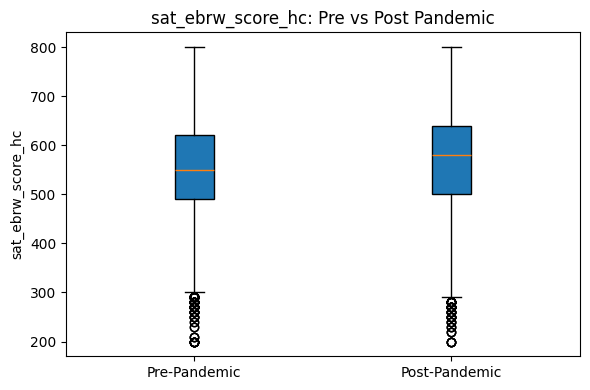

/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_92738/1107497811.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pre_data, post_data],


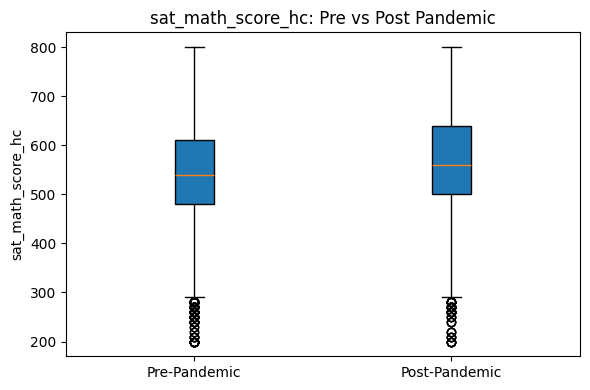

In [4]:
# Subset only rows where both scores exist
sub = cb.dropna(subset=['sat_ebrw_score_hc', 'sat_math_score_hc', 'pandemic_phase'])

for score_col in ['sat_ebrw_score_hc', 'sat_math_score_hc']:
    plt.figure(figsize=(6,4))
    # Prepare data lists in the order you want
    pre_data  = sub.loc[sub['pandemic_phase']=='pre', score_col]
    post_data = sub.loc[sub['pandemic_phase']=='post', score_col]

    plt.boxplot([pre_data, post_data],
                labels=['Pre-Pandemic','Post-Pandemic'],
                patch_artist=True)
    plt.ylabel(score_col)
    plt.title(f"{score_col}: Pre vs Post Pandemic")
    plt.tight_layout()
    plt.show()


Unique values in cb['ethnic']: [ 3  0  9  2 12  4  1  8 10]
Unique values in cb['eth_full'] after mapping: ['Black or African American' 'No response' 'White' 'Asian'
 'Two or more races, non-Hispanic' 'Hispanic or Latino'
 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'Other']
Unique values in cb['eth_short'] after mapping: ['Black' 'No resp' 'White' 'Asian' 'Two+ races' 'Hispanic'
 'American Indian' 'Pacific Islander' 'Other']

=== Summary: SAT_HC by Ethnicity & Pandemic Phase ===
           eth_short pandemic_phase  n_students  avg_sat_hc
0    American Indian           post         324      1053.0
1    American Indian            pre        1305       991.4
2              Asian           post        6272      1272.5
3              Asian            pre       11549      1242.4
4              Black           post        8269       991.4
5              Black            pre       39610       969.7
6           Hispanic           post        5564      1073.4

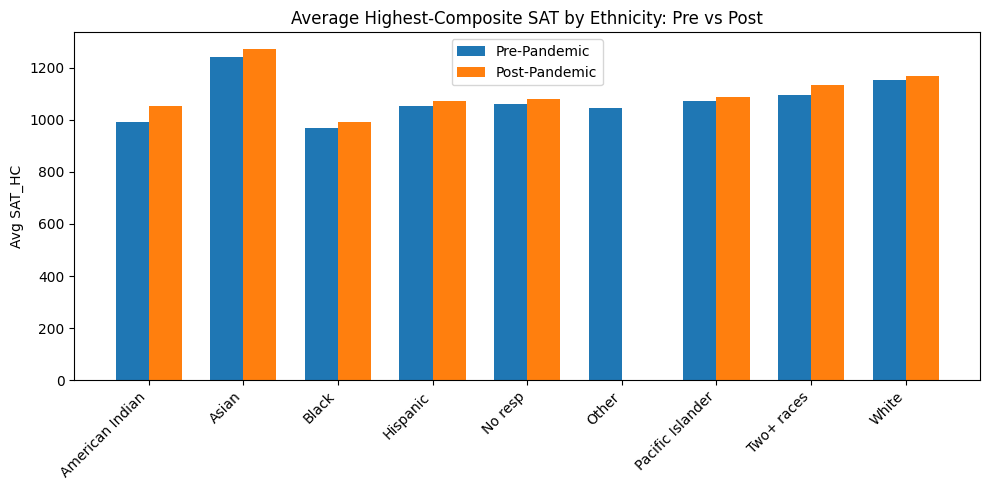

In [5]:
# ─── (A) Drop “mid” rows ───────────────────────────────────────────────────────
# (Assumes you already ran the cb['pandemic_phase'] = … logic.)
cb = cb[cb['pandemic_phase'] != 'mid']

# ─── (B) Inspect what’s in cb['ethnicity'] ────────────────────────────────────
print("Unique values in cb['ethnic']:", cb['ethnic'].unique())
# If this prints numeric codes (e.g. [0,1,2,3,4,8,9,10,12]), proceed to map them.

# ─── (C) Map numeric codes to the full‐text ethnicity ─────────────────────────
# Replace the dictionary keys/values below if your codebook differs.
code_to_full = {
    0:  'No response',
    1:  'American Indian or Alaska Native',
    2:  'Asian',
    3:  'Black or African American',
    4:  'Hispanic or Latino',
    8:  'Native Hawaiian or Other Pacific Islander',
    9:  'White',
    10: 'Other',
    12: 'Two or more races, non-Hispanic'
}

# Create a new column 'eth_full' that holds the full‐text string
cb['eth_full'] = cb['ethnic'].map(code_to_full)

# If you see any NaN in eth_full, that means the code in 'ethnicity' wasn't in code_to_full.

print("Unique values in cb['eth_full'] after mapping:", cb['eth_full'].unique())


# ─── (D) Map full‐text → short‐text using your short_labels dict ──────────────
short_labels = {
    'No response':                      'No resp',
    'American Indian or Alaska Native': 'American Indian',
    'Asian':                            'Asian',
    'Black or African American':        'Black',
    'Hispanic or Latino':               'Hispanic',
    'Native Hawaiian or Other Pacific Islander': 'Pacific Islander',
    'White':                            'White',
    'Other':                            'Other',
    'Two or more races, non-Hispanic':  'Two+ races'
}

cb['eth_short'] = cb['eth_full'].map(short_labels)
print("Unique values in cb['eth_short'] after mapping:", cb['eth_short'].unique())


# ─── (E) Now compute the summary table for SAT_HC by ethnicity & phase ─────────
grouped = (
    cb
    .dropna(subset=['eth_short', 'sat_total_score_hc'])
    .groupby(['eth_short','pandemic_phase'])['sat_total_score_hc']
    .agg(['count','mean'])
    .rename(columns={'count':'n_students','mean':'avg_sat_hc'})
    .round(1)
    .reset_index()
)

print("\n=== Summary: SAT_HC by Ethnicity & Pandemic Phase ===")
print(grouped)

# ─── (F) Pivot so pre/post appear as separate columns ──────────────────────────
pivoted = grouped.pivot(
    index='eth_short',
    columns='pandemic_phase',
    values=['n_students','avg_sat_hc']
)

# Flatten the MultiIndex columns to strings like 'n_students_pre', 'avg_sat_hc_post', etc.
pivoted.columns = [f"{stat}_{phase}" for stat, phase in pivoted.columns]
pivoted = pivoted.reset_index().sort_values('eth_short')

print("\n=== Pivoted Table (flattened) ===")
print(pivoted)
print("Pivoted columns:", pivoted.columns.tolist())


# ─── (G) Barplot: Pre vs Post average SAT_HC per ethnicity ─────────────────────
# Make sure the pre/post avg columns actually exist in pivoted
pre_col  = 'avg_sat_hc_pre'
post_col = 'avg_sat_hc_post'

# If you see different names in the printout above,
# just substitute those exact names here:
# e.g. pre_col = 'avg_sat_total_score_hc_pre', etc.

if pre_col not in pivoted.columns or post_col not in pivoted.columns:
    raise KeyError(f"Cannot find {pre_col} or {post_col} in pivoted columns {pivoted.columns.tolist()}")

ethnicities = pivoted['eth_short'].tolist()
pre_means  = pivoted[pre_col].tolist()
post_means = pivoted[post_col].tolist()

x = np.arange(len(ethnicities))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - width/2, pre_means, width, label='Pre-Pandemic')
ax.bar(x + width/2, post_means, width, label='Post-Pandemic')

ax.set_xticks(x)
ax.set_xticklabels(ethnicities, rotation=45, ha='right')
ax.set_ylabel('Avg SAT_HC')
ax.set_title('Average Highest‐Composite SAT by Ethnicity: Pre vs Post')
ax.legend()
plt.tight_layout()
plt.show()

Unique values in cb['eth_full'] after mapping: ['Black or African American' 'No response' 'White' 'Asian'
 'Two or more races, non-Hispanic' 'Hispanic or Latino'
 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'Other']
Unique values in cb['eth_short'] after mapping: ['Black' 'No resp' 'White' 'Asian' 'Two+ races' 'Hispanic'
 'American Indian' 'Pacific Islander' 'Other']
=== Aggregate AP Mean Score: Pre vs Post (rounded to 2 decimals) ===
                 count  mean  median   std  min  max
pandemic_phase                                      
post            133167  2.54     2.5  1.20  1.0  5.0
pre             216207  2.55     2.5  1.17  1.0  5.0


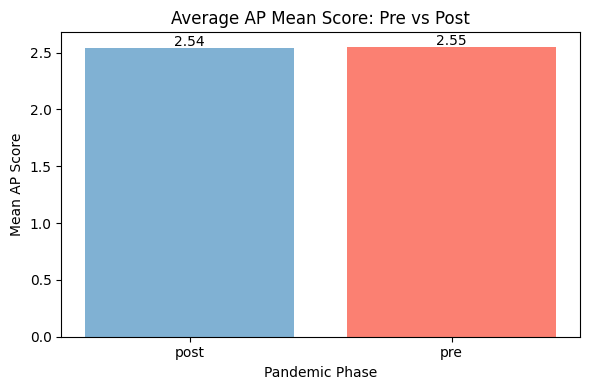


=== AP Mean by Ethnicity & Phase (rounded to 2 decimals) ===
                                  count  mean  median   std
eth_short        pandemic_phase                            
American Indian  post              1009  2.03    2.00  1.08
                 pre               1010  1.86    1.63  0.97
Asian            post             13572  3.08    3.00  1.23
                 pre              16638  3.05    3.00  1.22
Black            post             14801  1.85    1.50  1.00
                 pre              24260  1.88    2.00  0.97
Hispanic         post             16404  2.21    2.00  1.14
                 pre              24309  2.25    2.00  1.12
No resp          post              2838  2.73    3.00  1.27
                 pre               3185  2.59    2.50  1.25
Other            pre                 21  2.88    3.00  1.19
Pacific Islander post               112  2.14    2.00  1.17
                 pre                195  2.28    2.00  1.12
Two+ races       post              645

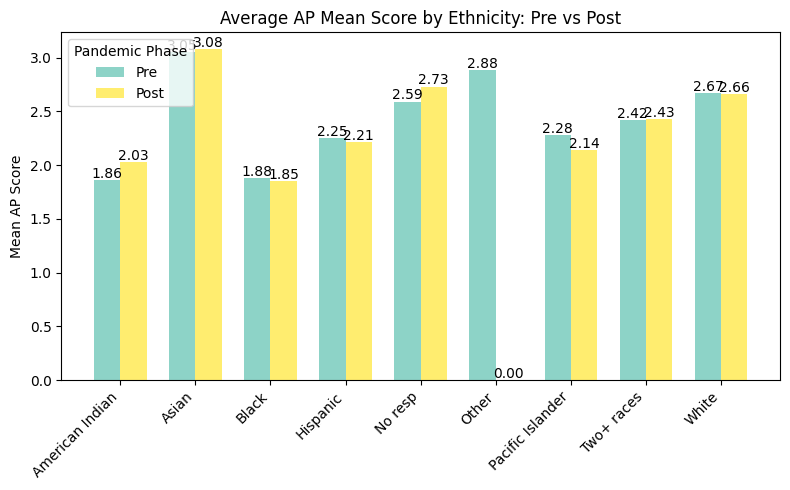

In [6]:
# ─── (C) Map numeric codes to the full‐text ethnicity ─────────────────────────
code_to_full = {
    0:  'No response',
    1:  'American Indian or Alaska Native',
    2:  'Asian',
    3:  'Black or African American',
    4:  'Hispanic or Latino',
    8:  'Native Hawaiian or Other Pacific Islander',
    9:  'White',
    10: 'Other',
    12: 'Two or more races, non-Hispanic'
}

# Create a new column 'eth_full' that holds the full‐text string
cb['eth_full'] = cb['ethnic'].map(code_to_full)

print("Unique values in cb['eth_full'] after mapping:", cb['eth_full'].unique())

# ─── (D) Map full‐text → short‐text using your short_labels dict ──────────────
short_labels = {
    'No response':                      'No resp',
    'American Indian or Alaska Native': 'American Indian',
    'Asian':                            'Asian',
    'Black or African American':        'Black',
    'Hispanic or Latino':               'Hispanic',
    'Native Hawaiian or Other Pacific Islander': 'Pacific Islander',
    'White':                            'White',
    'Other':                            'Other',
    'Two or more races, non-Hispanic':  'Two+ races'
}

cb['eth_short'] = cb['eth_full'].map(short_labels)
print("Unique values in cb['eth_short'] after mapping:", cb['eth_short'].unique())


# ─── 1) Identify ALL AP score columns by suffix 'gr' ─────────────────────────
ap_cols = [c for c in cb.columns if c.endswith('gr')]

# ─── 2) Compute per‐student aggregates ────────────────────────────────────────
cb['AP_total_taken'] = cb[ap_cols].notna().sum(axis=1)
cb['AP_mean_score']  = cb[ap_cols].mean(axis=1, skipna=True)
cb['AP_pass_count']  = (cb[ap_cols] >= 3).sum(axis=1)
cb['AP_percent_pass'] = cb['AP_pass_count'] / cb['AP_total_taken']

# If a student took zero AP exams, set their AP_mean_score and AP_percent_pass to NaN
cb.loc[cb['AP_total_taken'] == 0, ['AP_mean_score', 'AP_percent_pass']] = np.nan

# ─── 3) Example summary: Pre vs Post on AP_mean_score, rounded to 2 decimals ──
aggregate_summary = (
    cb
    .dropna(subset=['AP_mean_score'])
    .groupby('pandemic_phase')['AP_mean_score']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .round(2)
)

print("=== Aggregate AP Mean Score: Pre vs Post (rounded to 2 decimals) ===")
print(aggregate_summary)

# ─── 4) Visualization for aggregate AP mean (bar chart of mean by pandemic_phase) ─
plt.figure(figsize=(6, 4))
phases    = aggregate_summary.index.tolist()
mean_vals = aggregate_summary['mean'].tolist()
plt.bar(phases, mean_vals, color=['#80b1d3', '#fb8072'])
plt.title('Average AP Mean Score: Pre vs Post')
plt.xlabel('Pandemic Phase')
plt.ylabel('Mean AP Score')
for i, v in enumerate(mean_vals):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()


# ─── 5) Stratify by ethnicity (using 'eth_short'): Pre vs Post summary, rounded ─
ethnicity_ap_summary = (
    cb
    .dropna(subset=['eth_short', 'AP_mean_score'])
    .groupby(['eth_short', 'pandemic_phase'])['AP_mean_score']
    .agg(['count', 'mean', 'median', 'std'])
    .round(2)
)

print("\n=== AP Mean by Ethnicity & Phase (rounded to 2 decimals) ===")
print(ethnicity_ap_summary)

# ─── 6) Visualization for ethnicity stratification (grouped bar chart) ─────────
eth_df   = ethnicity_ap_summary.reset_index()
pivot_eth = eth_df.pivot(index='eth_short', columns='pandemic_phase', values='mean').fillna(0)

x     = np.arange(len(pivot_eth.index))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, pivot_eth['pre'],  width, label='Pre',  color='#8dd3c7')
ax.bar(x + width/2, pivot_eth['post'], width, label='Post', color='#ffed6f')

ax.set_xticks(x)
ax.set_xticklabels(pivot_eth.index, rotation=45, ha='right')
ax.set_ylabel('Mean AP Score')
ax.set_title('Average AP Mean Score by Ethnicity: Pre vs Post')
ax.legend(title='Pandemic Phase')

# Annotate each bar with its value
for i, eth in enumerate(pivot_eth.index):
    pre_val  = pivot_eth.loc[eth, 'pre']
    post_val = pivot_eth.loc[eth, 'post']
    ax.text(i - width/2, pre_val  + 0.02, f"{pre_val:.2f}", ha='center')
    ax.text(i + width/2, post_val + 0.02, f"{post_val:.2f}", ha='center')

plt.tight_layout()
plt.show()



=== Top 10 Schools: SAT Scores Pre vs Post ===
   school_id pandemic_phase  count     mean
0    410-490           post    993  1153.23
1    410-490            pre   1536  1173.95
2    600-302           post   1554  1245.03
3    600-302            pre   2797  1239.67
4    600-312           post    795  1171.90
5    600-312            pre   1797  1179.79
6    600-445           post    297  1070.64
7    600-445            pre   1124  1063.15
8    600-466           post   1156  1207.58
9    600-466            pre   1893  1211.66
10   600-508           post    737  1252.50
11   600-508            pre   1437  1252.85
12   600-535           post    742  1123.02
13   600-535            pre   1476  1147.72
14   920-412           post    794  1307.93
15   920-412            pre   1713  1275.86
16   920-441           post    938  1278.34
17   920-441            pre   2618  1255.68
18   920-526           post    986  1256.20
19   920-526            pre   2301  1257.22


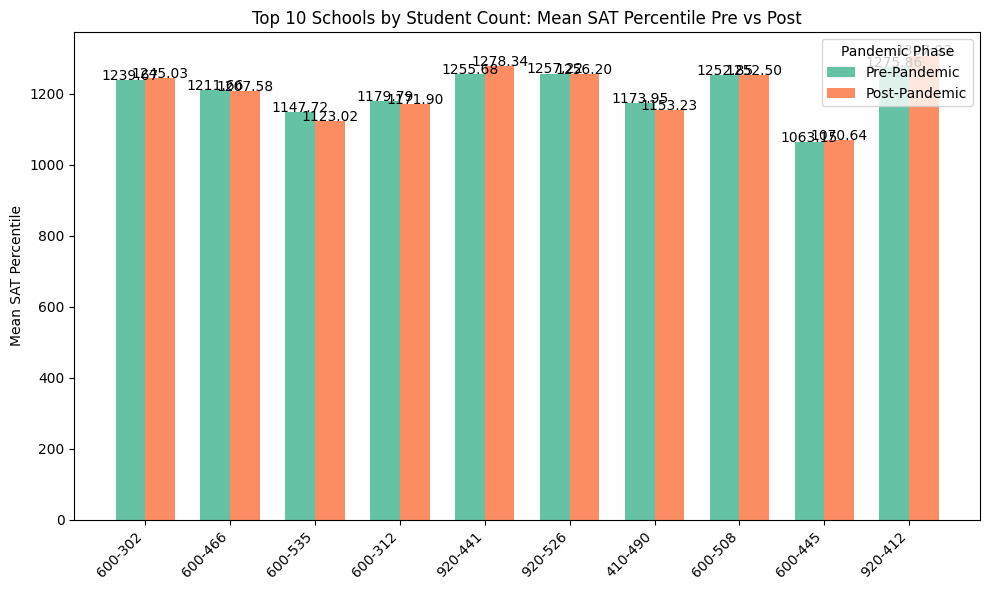

In [9]:
# 1) Identify the top 10 largest schools by student count
school_counts = cb['school_id'].value_counts()
top10_schools = school_counts.head(10).index.tolist()

# 2) Subset to only those top 10 schools
cb_top10 = cb[cb['school_id'].isin(top10_schools)]

# 3) Compute mean SAT percentile for each school, split by pandemic_phase
school_summary = (
    cb_top10
    .dropna(subset=['sat_total_score_hc'])  # only keep rows with a valid SAT percentile
    .groupby(['school_id', 'pandemic_phase'])['sat_total_score_hc']
    .agg(['count', 'mean'])
    .round(2)
    .reset_index()
)

print("=== Top 10 Schools: SAT Scores Pre vs Post ===")
print(school_summary)

# 4) Pivot so “pre” and “post” appear as separate columns for plotting
pivot_school = school_summary.pivot(
    index='school_id',
    columns='pandemic_phase',
    values='mean'
).fillna(0)  # fill NaN with 0 (if a school has no pre or post data)

pivot_school = pivot_school.reindex(top10_schools)  # ensure original top10 order

# 5) Create a grouped bar chart for the 10 schools
x = np.arange(len(pivot_school.index))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, pivot_school['pre'],  width, label='Pre-Pandemic',  color='#66c2a5')
ax.bar(x + width/2, pivot_school['post'], width, label='Post-Pandemic', color='#fc8d62')

ax.set_xticks(x)
ax.set_xticklabels(pivot_school.index, rotation=45, ha='right')
ax.set_ylabel('Mean SAT Percentile')
ax.set_title('Top 10 Schools by Student Count: Mean SAT Percentile Pre vs Post')
ax.legend(title='Pandemic Phase')

# Annotate each bar with its mean value
for i, school in enumerate(pivot_school.index):
    pre_val  = pivot_school.loc[school, 'pre']
    post_val = pivot_school.loc[school, 'post']
    ax.text(i - width/2, pre_val  + 0.5, f"{pre_val:.2f}", ha='center')
    ax.text(i + width/2, post_val + 0.5, f"{post_val:.2f}", ha='center')

plt.tight_layout()
plt.show()